In [30]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import Tensor
from datetime import datetime
import math
import random
from mynn import *
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
initLogging("Common init")

dtype = torch.float
log("dtype", dtype)

dvc = torch.device("cpu")
log("device", dvc.type)

contextSize = 3
log("contextSize", contextSize)


Common init:         -------------------------- 2023-07-06 19:08:14
dtype:               torch.float32
device:              cpu
contextSize:         3


In [32]:
logSection("Prepare dataset")

filePath = "names.txt"
log("filePath", filePath)

trRatio = 0.8
log("trRatio", trRatio)

devRatio = 0.9
log("devRatio", devRatio)

wordShufflingSeed = 42
log("wordShufflingSeed", wordShufflingSeed)

words = readFileSplitByLine(filePath)
random.seed(wordShufflingSeed)
random.shuffle(words)
log("first few words", words[:5])

lenWords = len(words);
log("lenWords", lenWords)

allPossibleChars = sorted(list(set("".join(words))))
log("allPossibleChars", allPossibleChars)

stoi = sToI(allPossibleChars)
log("stoi", stoi)

itos = iToS(stoi)
log("itos", itos)

vocabularyLength = len(itos)
log("vocabularyLength", vocabularyLength)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos, dvc)
log("data set training", lenTrain, trX.shape, trY.shape, trWords[:3])

endVal = int(devRatio * lenWords)
valWords = words[lenTrain:endVal];
valX, valY = buildDataSet(valWords, contextSize, stoi, itos, dvc)
log("data set validation", endVal - lenTrain, valX.shape, valY.shape, valWords[:3])

lenTest = lenWords - endVal
tstWords = words[endVal:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos, dvc)
log("data set test", lenTest, tstX.shape, tstY.shape, tstWords[:3])

Prepare dataset:     -------------------------- 2023-07-06 19:08:14
filePath:            names.txt
trRatio:             0.8
devRatio:            0.9
wordShufflingSeed:   42
first few words:     ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:            32033
allPossibleChars:    ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos:                {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocabularyLength:    27
data set training:   25626 torch.Size([18

Build network:       -------------------------- 2023-07-06 19:08:15
embeddingDims:       10
hiddenLayerSize:     200
learningSeed:        2147483647
W1ratio:             0.2
b1ratio:             0.01
W2ratio:             0.1
b2ratio:             0
parametersCount:     12097
random probability:  3.2958


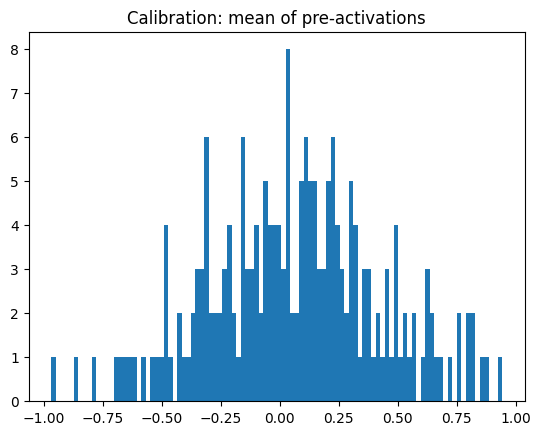

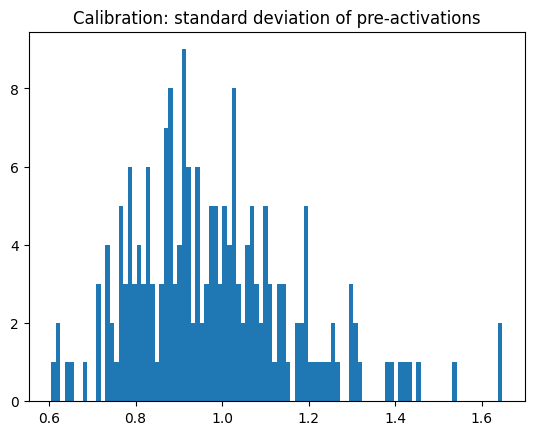

In [33]:
logSection("Build network")

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 200
log("hiddenLayerSize", hiddenLayerSize)

learningSeed = 2147483647
log("learningSeed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

np = makeNetwork(g, vocabularyLength, embeddingDims, contextSize, hiddenLayerSize, dvc)
log("parametersCount", sum(p.nelement() for p in np.all))

log("random probability", f"{-torch.tensor(1 / vocabularyLength).log().item():.4f}")

cal = calibrateBatchNorm(np, trX)

plt.figure()
plt.hist(cal.mean.tolist(), 100)
plt.title("Calibration: mean of pre-activations")

plt.figure()
plt.hist(cal.std.tolist(), 100)
plt.title("Calibration: standard deviation of pre-activations")

@torch.no_grad()
def trLoss(): return getLoss(np, cal, np.C[trX], trY)

@torch.no_grad()
def valLoss(): return getLoss(np, cal, np.C[valX], valY)

@torch.no_grad()
def tstLoss(): return getLoss(np, cal, np.C[tstX], tstY)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Learning:            -------------------------- 2023-07-06 19:08:15
trainingBatchSize:   32
trainingSteps: :     5708
maxIteration:        200000
repeats:             36
maxLr:               0.14
minLr:               0.0001
actualIterations:    200000
  0,      0 losses:     0.0000       3.6903     3.6829     3.6889
  1,   5708 losses:     2.1087       2.2960     2.3068     2.3090
  2,  11416 losses:     2.2584       2.2237     2.2411     2.2411
  3,  17124 losses:     2.3740       2.2137     2.2339     2.2345
  4,  22832 losses:     2.0893       2.1922     2.2140     2.2197
  5,  28540 losses:     1.7319       2.1899     2.2135     2.2175
  6,  34248 losses:     2.5455       2.1657     2.1930     2.1960
  7,  39956 losses:     1.7967       2.1602     2.1992     2.1912
  8,  45664 losses:     1.7418       2.1540     2.1927     2.1918
  9,  51372 losses:     1.9720       2.1515     2.1841     2.1896
 10,  57080 losses:     2.3275       2.1408     2.1811     2.1838
 11,  62788 losses:   

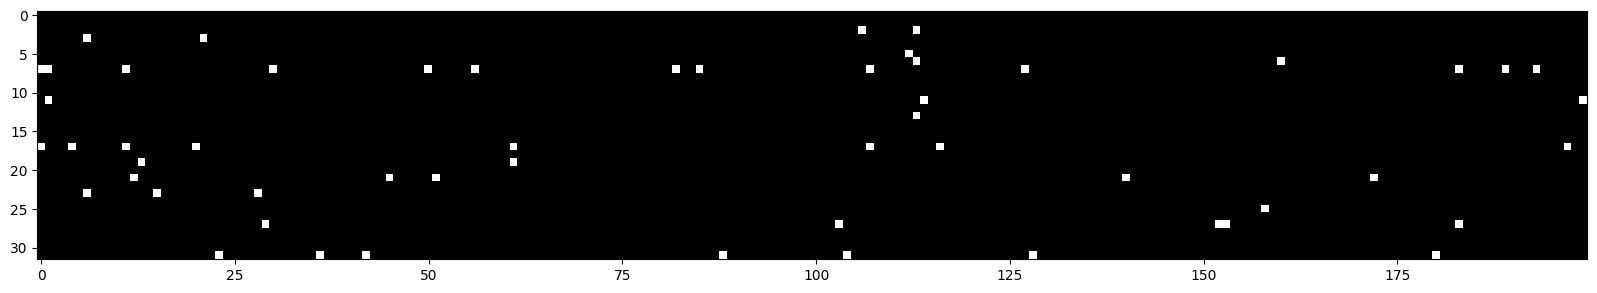

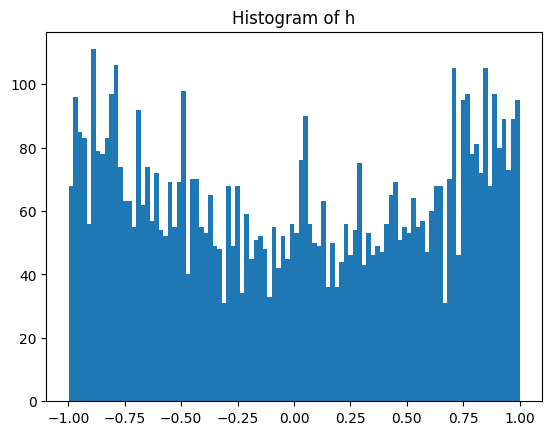

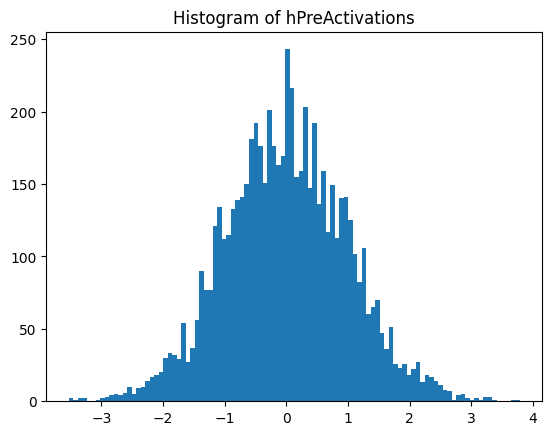

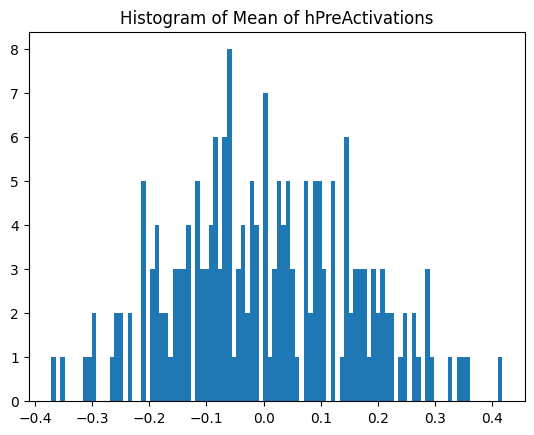

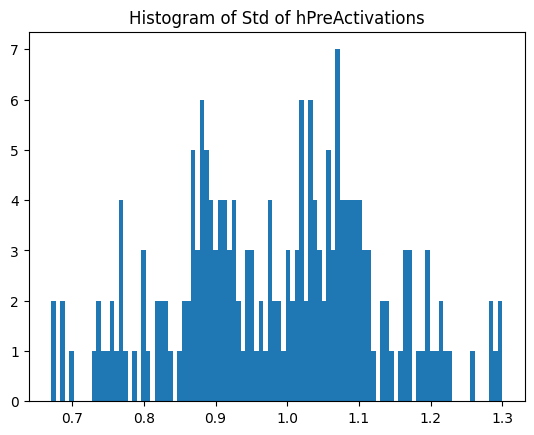

In [34]:
logSection("Learning")

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

trXLength = trX.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

maxIteration = 200_000
log("maxIteration",maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
up = UpdateNetResult()

i = 0
for repeat in range(repeats):
    
    if i >= maxIteration:
        break;

    logSimple(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("break")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, cal, trX, trY, miniBatchIxs)
        
        backwardPass(np.all, fr.loss)

        if i == 1:
            plt.figure(figsize=(20, 10))
            plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")
            
            plt.figure()
            plt.hist(fr.h.view(-1).tolist(), 100)
            plt.title('Histogram of h')

            plt.figure()
            plt.hist(fr.hPreActivations.view(-1).tolist(), 100)
            plt.title('Histogram of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.mean(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Mean of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.std(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Std of hPreActivations')

        up = updateNet(np.all, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())
        
        i += 1

logLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#log("best learning rate", bestLr)
log("emb.shape", fr.emb.shape)
log("h.shape", fr.h.shape)
log("logits.shape", fr.logits.shape)

In [45]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

samples = sample(np, cal, gSampling, contextSize, itos, 20)
for s in samples:
    logSimple("".join(s.values) + "  ", end="")
    for p in [s.prob] + s.probs:
        logSimple(f"{(p * 100):.0f} ", end="")
    logSimple()

Sampling:            -------------------------- 2023-07-06 19:09:56
samplingSeed:        2147483657
carman.  4746424 124 1109 529 294 1052 1571 937 
amelle.  2485993 384 239 597 652 370 799 1642 
khy.  1309 250 213 478 206 
mili.  17092 207 425 625 614 253 
taty.  867 108 838 24 358 563 
skanden.  257236 175 76 386 275 327 420 573 1849 
jazonel.  149585 210 1411 98 160 1238 118 365 484 
deliah.  2010888 144 838 392 585 626 313 2597 
jareei.  18436 210 1411 107 755 540 9 1115 
ner.  2650 94 387 176 1649 
kiah.  53978 250 261 204 783 2597 
maiiv.  13 207 1555 146 6 12 235 
kaleigh.  245250602 250 1172 302 612 463 1572 2460 2026 
ham.  4686 76 1537 205 788 
join.  5539 210 465 41 837 826 
quinthorniver.  3167772777 7 2441 1309 1678 328 239 703 665 226 465 111 371 1044 665 
jadique.  215223 210 1411 83 495 5 1330 2218 903 
jermaijaristin.  1813827689 210 445 839 400 1285 151 19 2125 6 667 263 850 760 1246 1398 
jenni.  226806 210 445 597 595 396 1037 
sabee.  14061 175 808 127 1525 46 671 

In [36]:
ps = calcProb(np, cal, "carman.", contextSize, stoi)
op = calcOneProb(ps)
for p in [op] + ps:
    logSimple(f"{(p * 100):.0f} ", end="")

4746424 124 1109 529 294 1052 1571 937 

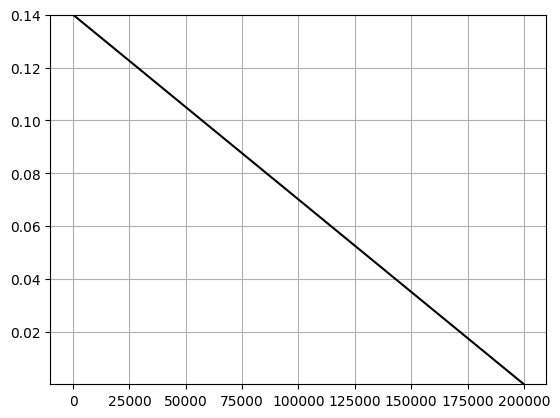

Actual min max LR 0.14 0.0001006994999999955


In [37]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print("Actual min max LR", max(lrAtIx), min(lrAtIx))

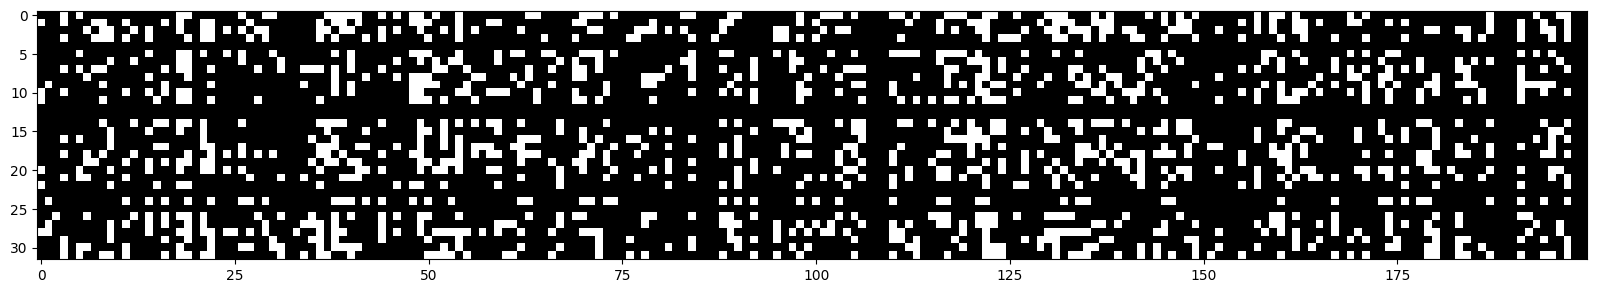

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

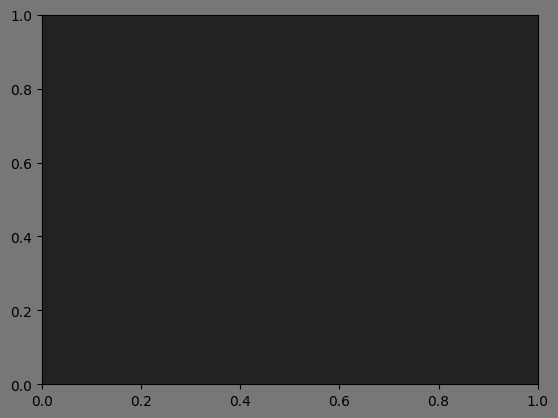

In [39]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
#ax.plot(lrAtIx, lossAtIx)
plt.show()

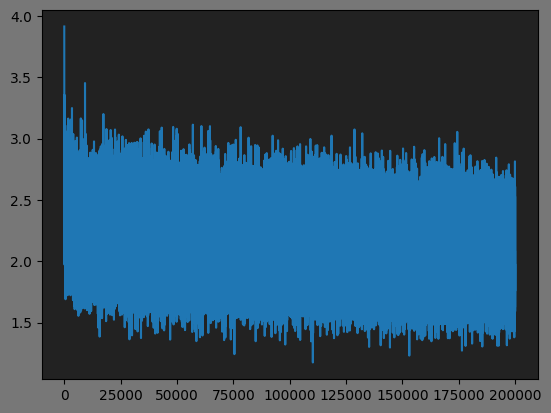

In [40]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, lossAtIx)
plt.show()

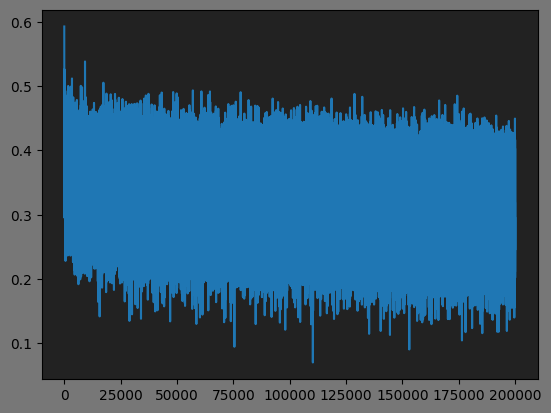

In [41]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, logLossAtIx)
plt.show()

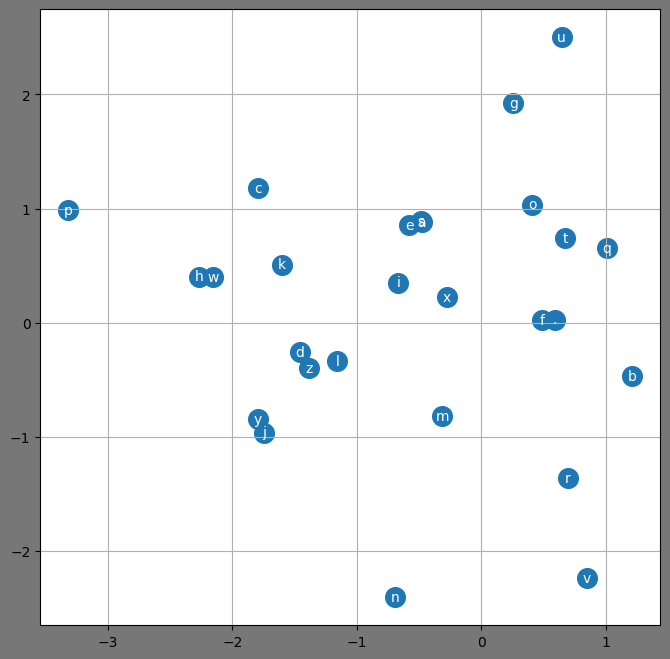

In [42]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#777777")
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid()

In [43]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([27, 10]),
 torch.Size([182625, 3]),
 torch.Size([182625, 3, 10]),
 tensor([[ 0.5911,  0.0273,  0.0431, -0.0914,  0.3696, -0.0505, -0.4540, -0.0206,
          -0.1082,  0.1569],
         [-0.4791,  0.8817, -0.1414, -0.2341,  0.8450,  1.7884,  0.5886, -0.9741,
           0.4410, -1.1158],
         [ 1.2114, -0.4685, -1.8173,  0.5023, -0.8494,  2.3244,  3.0912, -0.2059,
          -0.8432,  1.3795],
         [-1.7903,  1.1772,  0.8255,  1.3653, -0.9138, -0.5689, -1.4770,  1.8187,
          -1.0626,  1.2901],
         [-1.4579, -0.2604, -0.7949,  1.3748, -1.3305,  0.8866, -0.3106,  1.1794,
           0.6918, -1.6059]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([[[ 0.5911,  0.0273,  0.0431, -0.0914,  0.3696, -0.0505, -0.4540,
           -0.0206, -0.1082,  0.1569],
          [ 0.5911,  0.0273,  0.0431, -0.0914,  0.3696, -0.0505, -0.4540,
           -0.0206, -0.1082,  0.15

In [44]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
